In [16]:
# Import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

!pip install cplex
import cplex

!apt install coinor-libipopt-dev
!pip install ipopt
import ipopt


Reading package lists... Done
Building dependency tree       
Reading state information... Done
coinor-libipopt-dev is already the newest version (3.11.9-2.1ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [17]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
   x_optimal = x_init
   cash_optimal = cash_init
   return x_optimal, cash_optimal

In [18]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    port_value = np.dot(cur_prices,x_init) + cash_init

    x_optimal = np.floor(np.full(20,1/20)*port_value / cur_prices)

    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005

    cash_optimal = port_value - np.dot(cur_prices,x_optimal) - tran_cost
        
    return x_optimal, cash_optimal

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
   port_value = np.dot(cur_prices,x_init) + cash_init

   n = 20
   cpx = cplex.Cplex()
   cpx.objective.set_sense(cpx.objective.sense.minimize)

   c  = [0.0] * n
   lb = [0.0] * n
   ub = [1.0] * n

   A = []
   for k in range(n):
    A.append([[0,1],[1.0, 0]])
   
   var_names = ["w_%s" % i for i in range(1,n+1)]
   cpx.linear_constraints.add(rhs=[1.0,0],senses='EG')
   cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
   Qmat = [[list(range(n)),list(2*Q[k,:])] for k in range(n)]
   cpx.objective.set_quadratic(Qmat)
   cpx.parameters.threads.set(4) 
   cpx.set_results_stream(None)
   cpx.set_warning_stream(None)
   cpx.solve()
   
   w = np.array(cpx.solution.get_values())
   
   x_optimal = np.floor(w*port_value/cur_prices)
    
   tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005

   cash_optimal = port_value - np.dot(cur_prices,x_optimal) - tran_cost


   return x_optimal, cash_optimal

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    port_value = np.dot(cur_prices,x_init) + cash_init

    n = 21
    r_rf = 0.045
    day_rf = r_rf / 252

    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    c = [0]*n
    lb = [0]*n
    ub = [np.inf]*n

    Q = np.append(Q,np.zeros((20,1)), axis=1)
    zero_arr = np.zeros((21))
    Q = np.vstack([Q,zero_arr])

    diff = mu - day_rf * np.ones(20)

    A = []
    for k in range(n-1):
        A.append([[0,1],[diff[k],1.0]])
    A.append([[0,1],[0,-1.0]])

    var_names = ['y_%s'% i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EE')
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A,names=var_names)
    Qmat = [[list(range(n)),list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()

    if cpx.solution.get_status_string()== 'infeasible':
      # If the solution is infeasible, just keeps the last period's position and cash
      x_optimal = x_init
      cash_optimal = cash_init
    else:
      ans = np.array(cpx.solution.get_values())

      w = ans[0:20]/ans[20]

      x_optimal = np.floor(w*port_value/cur_prices)

      tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005

      cash_optimal = port_value - np.dot(cur_prices,x_optimal) - tran_cost
    
    return x_optimal, cash_optimal


In [19]:
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
  port_value = np.dot(cur_prices,x_init) + cash_init
  n = 20
  
  class erc(object):
    def __init__(self):
        pass
  
    def objective(self, x):
        # The callback for calculating the objective
        y = x * np.dot(Q, x)
        fval = 0
        for i in range(n):
            for j in range(i,n):
                xij = y[i] - y[j]
                fval = fval + xij*xij
        fval = 2*fval
        return fval
  
    def gradient(self, x):
        # The callback for calculating the gradient
        grad = np.zeros(n)
        # Insert your gradient computations here
        # You can use finite differences to check the gradient
        y = x * np.dot(Q, x)
        for i in range(n):
          for j in range(n):
            diff1 = np.dot(Q[i],x) + np.dot(Q[i][i],x[i])
            diff2 = np.dot(Q[i][j], x[i])
            g = (y[i]-y[j]) * (diff1 - diff2)
            grad[i] += g
          grad[i] *= 4
        return grad
  
    def constraints(self, x):
        # The callback for calculating the constraints
        return [1.0] * n
    
    def jacobian(self, x):
        # The callback for calculating the Jacobian
        return np.array([[1.0] * n])

  w0 = (x_init*cur_prices)/port_value
  lb = [0.0] * n  # lower bounds on variables
  ub = [1.0] * n  # upper bounds on variables
  cl = [1]        # lower bounds on constraints
  cu = [1]        # upper bounds on constraints

  # Define IPOPT problem
  nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
  
  # Set the IPOPT options
  nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
  nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
  nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
  nlp.add_option('tol'.encode('utf-8'), 1e-10)

  # Solve the problem
  w_erc, info = nlp.solve(w0)

  x_optimal = np.floor(w_erc*port_value / cur_prices)
  tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
  cash_optimal = port_value - np.dot(cur_prices,x_optimal) - tran_cost
  
  return x_optimal, cash_optimal


In [20]:
def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices): 
  port_value = np.dot(cur_prices,x_init) + cash_init
  n = 20
  
  class erc(object):
    def __init__(self):
        pass

    def objective(self, x):
        # The callback for calculating the objective
        y = x * np.dot(Q, x)
        fval = 0
        for i in range(n):
            for j in range(i,n):
                xij = y[i] - y[j]
                fval = fval + xij*xij
        fval = 2*fval
        return fval

    def gradient(self, x):
        # The callback for calculating the gradient
        grad = np.zeros(n)
        # Insert your gradient computations here
        # You can use finite differences to check the gradient
        y = x * np.dot(Q, x)
        for i in range(n):
          for j in range(n):
            diff1 = np.dot(Q[i],x) + np.dot(Q[i][i],x[i])
            diff2 = np.dot(Q[i][j], x[i])
            g = (y[i]-y[j]) * (diff1 - diff2)
            grad[i] += g
          grad[i] *= 4
        return grad

    def constraints(self, x):
        # The callback for calculating the constraints
        return [1.0] * n

    def jacobian(self, x):
        # The callback for calculating the Jacobian
        return np.array([[1.0] * n])

  bor_val = init_value
  
  interest = bor_val*r_rf2008_2009/6
  
  if period == 1:
    port_value = port_value + bor_val
  
  w0 = (x_init*cur_prices)/port_value    
  lb = [0.0] * n  # lower bounds on variables
  ub = [1.0] * n  # upper bounds on variables
  cl = [1]        # lower bounds on constraints
  cu = [1]        # upper bounds on constraints

  # Define IPOPT problem
  nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
  
  # Set the IPOPT options
  nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
  nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
  nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
  nlp.add_option('tol'.encode('utf-8'), 1e-10)

  # Solve the problem
  w_erc, info = nlp.solve(w0)

  x_optimal = np.floor(w_erc*port_value / cur_prices)
  tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
  cash_optimal = port_value - np.dot(cur_prices,x_optimal) - tran_cost - interest

  return x_optimal, cash_optimal


In [21]:
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
  port_value = np.dot(cur_prices,x_init) + cash_init
  n = 20

  cpx = cplex.Cplex()
  cpx.objective.set_sense(cpx.objective.sense.minimize)
  c  = [0.0] * n
  lb = [0.0] * n
  ub = [1.0] * n
  
  A = []
  for k in range(n):
    A.append([[0,1],[1.0,mu[k]]])
  
  var_names = ["w_%s" % i for i in range(1,n+1)]

  x_minVar, cash_minVar = strat_min_variance(x_init, cash_init, mu, Q, cur_prices)
  w_minVar = (x_minVar*cur_prices)/port_value
  ret_minVar = np.dot(mu, w_minVar)
  Portf_Retn = ret_minVar # target return
  var_matr = np.diag(np.diag(Q))
  Qq_rMV = var_matr
  w0 = (x_init*cur_prices)/port_value
  rob_init = np.dot(w0, np.dot(var_matr, w0)) # return estimation error of initial portfolio
  rob_bnd  = rob_init # target return estimation error

  cpx.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")
  cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
  Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
  cpx.objective.set_quadratic(Qmat)
  Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(var_matr))
  cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")

  cpx.parameters.threads.set(4)
  cpx.parameters.timelimit.set(60)
  cpx.parameters.barrier.qcpconvergetol.set(1e-12)
  cpx.set_results_stream(None)
  cpx.set_warning_stream(None)
  cpx.solve()

  w_rMV = np.array(cpx.solution.get_values())
  w_rMV[w_rMV<1e-6] = 0 #round near-zero
  w_rMV = w_rMV / np.sum(w_rMV)

  x_optimal = np.floor(w_rMV*port_value / cur_prices)
  tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
  cash_optimal = port_value - np.dot(cur_prices,x_optimal) - tran_cost


  return x_optimal, cash_optimal

In [22]:
# Input file
input_file_prices = 'Daily_closing_prices20082009.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
# N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

# List of begin and end portfolip value for each period
port_beg_end_lst = [0] * N_strat
for i in range(len(port_beg_end_lst)):
  port_beg_end_lst[i] = []

for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 8:
       cur_year  = 8 + math.floor(period/7)
   else:
       cur_year  = 2008 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      if cash[strategy, period-1] < 0:
        port_value = np.dot(cur_prices, curr_positions) + curr_cash
        ratio = x[strategy, period-1]/sum(x[strategy, period-1])
        exce_cash = abs(cash[strategy, period-1])*ratio
        exce_x = np.ceil(exce_cash/cur_prices)
        x[strategy, period-1] = x[strategy, period-1] - exce_x
        new_tran_cost = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
        cash[strategy, period-1] = port_value - np.dot(cur_prices,x[strategy, period-1]) - new_tran_cost
      
      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      # We need to subtract borrow value (= init_value) when we calculate the portfolio value from applying leveraged equal risk contribbutions
      if strategy == 5:
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value
      else:
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
      port_beg_end_lst[strategy].append([portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]])

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)



Initial portfolio value = $ 385097.15


Period 1: start date 01/02/2008, end date 02/29/2008
  Strategy "Buy and Hold", value begin = $ 385097.15, value end = $ 325918.34
  Strategy "Equally Weighted Portfolio", value begin = $ 381649.89, value end = $ 326929.57
  Strategy "Mininum Variance Portfolio", value begin = $ 383262.49, value end = $ 327144.09
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 381265.54, value end = $ 332652.59
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 381854.88, value end = $ 328109.33
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 378354.15, value end = $ 306048.14
  Strategy "Robust Optimization Portfolio", value begin = $ 383262.39, value end = $ 327133.70

Period 2: start date 03/03/2008, end date 04/30/2008
  Strategy "Buy and Hold", value begin = $ 325807.08, value end = $ 349997.20
  Strategy "Equally Weighted Portfolio", value begin = $ 322097.69, value end = $ 354821.22
  Strategy "Mininum

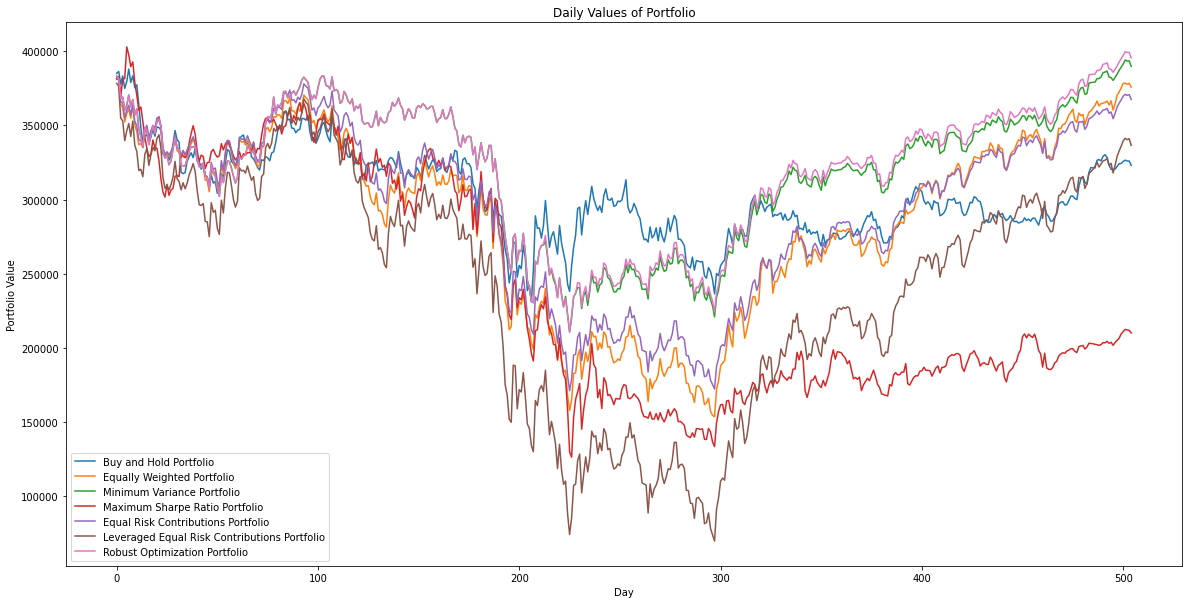

In [23]:
# Plot results
# Daily Values of portfolio
plt.figure(figsize=(20,10))
plt.plot(portf_value[0],label='Buy and Hold Portfolio')
plt.plot(portf_value[1],label='Equally Weighted Portfolio')
plt.plot(portf_value[2],label='Minimum Variance Portfolio')
plt.plot(portf_value[3],label='Maximum Sharpe Ratio Portfolio')
plt.plot(portf_value[4],label='Equal Risk Contributions Portfolio')
plt.plot(portf_value[5],label='Leveraged Equal Risk Contributions Portfolio')
plt.plot(portf_value[6],label='Robust Optimization Portfolio')
plt.legend()
plt.title('Daily Values of Portfolio')
plt.xlabel('Day')
plt.ylabel('Portfolio Value')
plt.show()

In [24]:
# Maximum drawdown of portfolio

df_port_values = pd.DataFrame()
for i in range(7):
    df_port_values[str(i)] = portf_value[i].flatten()

period = [0]*12
for i in range(12):
  period[i] = [0,0]

period[0][1] = df_port_values.index[df_port_values['0'] == port_beg_end_lst[0][0][1]].tolist()[0]

for i in range(1,12):
  end_per_index = df_port_values.index[df_port_values['0'] == port_beg_end_lst[0][i][1]].tolist()[0]
  period[i] = [period[i-1][1]+1, end_per_index]

df_max_drawdown = pd.DataFrame() 
for i in range(7):
  for j in range(12):
    beg = period[j][0]
    end = period[j][1]
    max_port = df_port_values.loc[beg:end,'{}'.format(i)].rolling(window=end-beg+1, min_periods=1).max()
    daily_drawdown = df_port_values.loc[beg:end,'{}'.format(i)]/max_port - 1
    
    # Next we calculate the minimum (negative) daily drawdown 
    if j == 0:
      the_max_daily_drawdown = daily_drawdown.rolling(window=end-beg+1, min_periods=1).min()
    else:
      max_daily_drawdown = daily_drawdown.rolling(window=end-beg+1, min_periods=1).min()
      the_max_daily_drawdown = the_max_daily_drawdown.append(max_daily_drawdown)

  df_max_drawdown[strategy_names[i]] = the_max_daily_drawdown


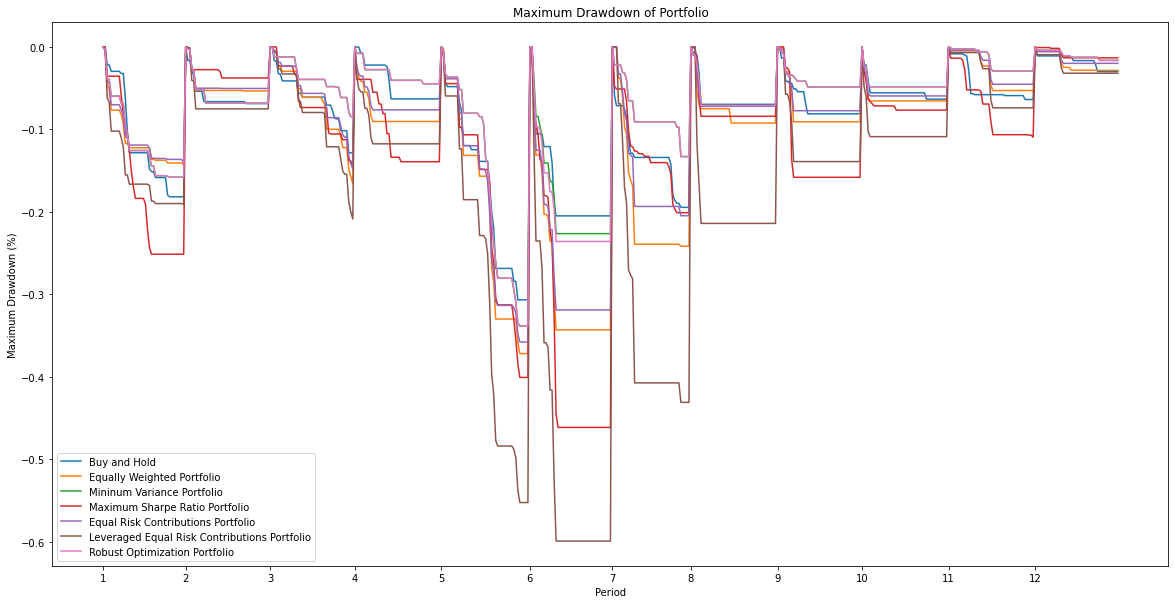

In [25]:
num_period = []
for i in range(1,13):
  num_period.append(i)

period_start_day = []
for i in range(12):
  period_start_day.append(period[i][0])

df_max_drawdown.plot(figsize=(20,10))
plt.title('Maximum Drawdown of Portfolio')
plt.xlabel('Period')
plt.ylabel('Maximum Drawdown (%)')
plt.xticks(period_start_day, num_period)
plt.show()

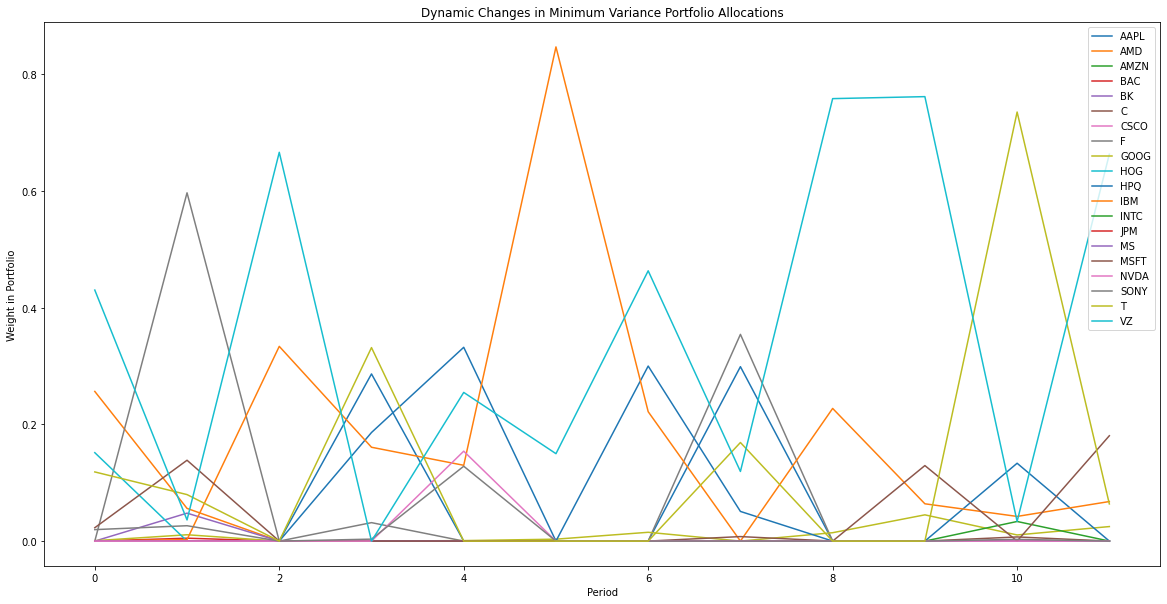

In [26]:
# Dynamic Changes in Minimum Variance Portfolio Allocations
stocks = df.columns[1:]
w = []

for period in range(1, N_periods+1):
    w.append(x[2, period-1]/sum(x[2, period-1]))
    
min_v_df = pd.DataFrame(np.array(w), columns=stocks,)
min_v_df.plot(figsize=(20,10))
plt.title('Dynamic Changes in Minimum Variance Portfolio Allocations')
plt.xlabel('Period')
plt.ylabel('Weight in Portfolio')
plt.show()

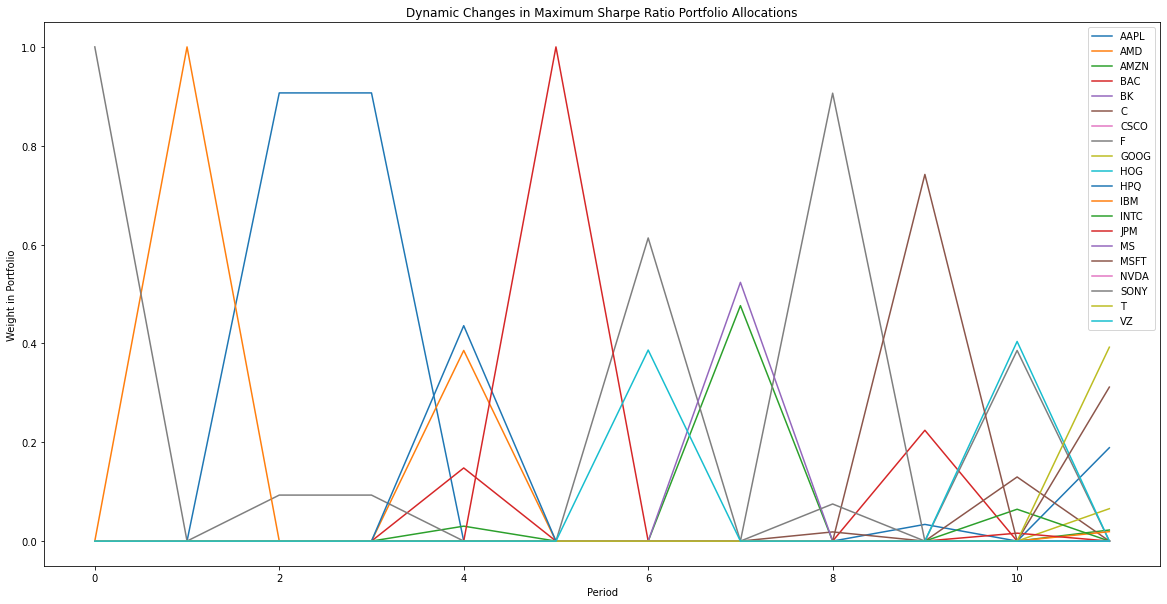

In [27]:
# Dynamic Changes in Maximumm Sharpe Ratio Portfolio Allocations

stocks = df.columns[1:]
w = []

for period in range(1, N_periods+1):
    w.append(x[3, period-1]/sum(x[3, period-1]))
    
max_s_df = pd.DataFrame(np.array(w), columns=stocks,)
max_s_df.plot(figsize=(20,10))
plt.title('Dynamic Changes in Maximum Sharpe Ratio Portfolio Allocations')
plt.xlabel('Period')
plt.ylabel('Weight in Portfolio')
plt.show()

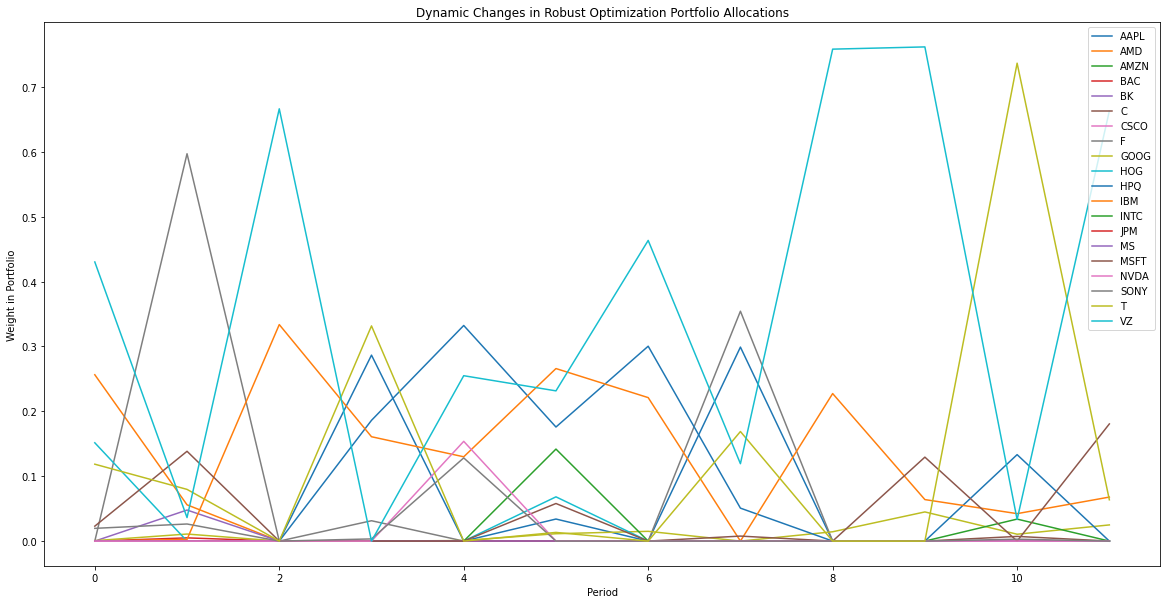

In [32]:
# Dynamic Changes in Robust Optimization Portfolio Allocations
stocks = df.columns[1:]
w = []

for period in range(1, N_periods+1):
    w.append(x[6, period-1]/sum(x[6, period-1]))
    
rob_o_df = pd.DataFrame(np.array(w), columns=stocks,)
rob_o_df.plot(figsize=(20,10))
plt.title('Dynamic Changes in Robust Optimization Portfolio Allocations')
plt.xlabel('Period')
plt.ylabel('Weight in Portfolio')
plt.legend(loc='upper right')
plt.show()